In [50]:
import pandas as pd
import numpy as np
from binance.client import Client
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
#Read in data
#https://github.com/binance/binance-public-data/

client = Client()

# Set the start date and current date
start_date = "1 Jan, 2020"
end_date = datetime.now().strftime("%d %b, %Y")

# Fetch the klines/candlestick data
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, start_date, end_date)

# Create a DataFrame
df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Convert relevant columns to float
float_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
df[float_columns] = df[float_columns].astype(float)

In [52]:
copy = df
df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
timestamp,,,,,,,,,,,
2020-01-01,7195.24,7255.0,7175.15,7200.85,16792.388165,1577923199999,1.212145e+08,194010.0,8946.955535,6.459779e+07,0
2020-01-02,7200.77,7212.5,6924.74,6965.71,31951.483932,1578009599999,2.259823e+08,302667.0,15141.611340,1.070608e+08,0
2020-01-03,6965.49,7405.0,6871.04,7344.96,68428.500451,1578095999999,4.950986e+08,519854.0,35595.496273,2.577131e+08,0
2020-01-04,7345.00,7404.0,7272.21,7354.11,29987.974977,1578182399999,2.198742e+08,279370.0,16369.382248,1.200351e+08,0
2020-01-05,7354.19,7495.0,7318.00,7358.75,38331.085604,1578268799999,2.848487e+08,329209.0,19455.369564,1.446001e+08,0


Building linear regression model using various inputs and predicting closing price

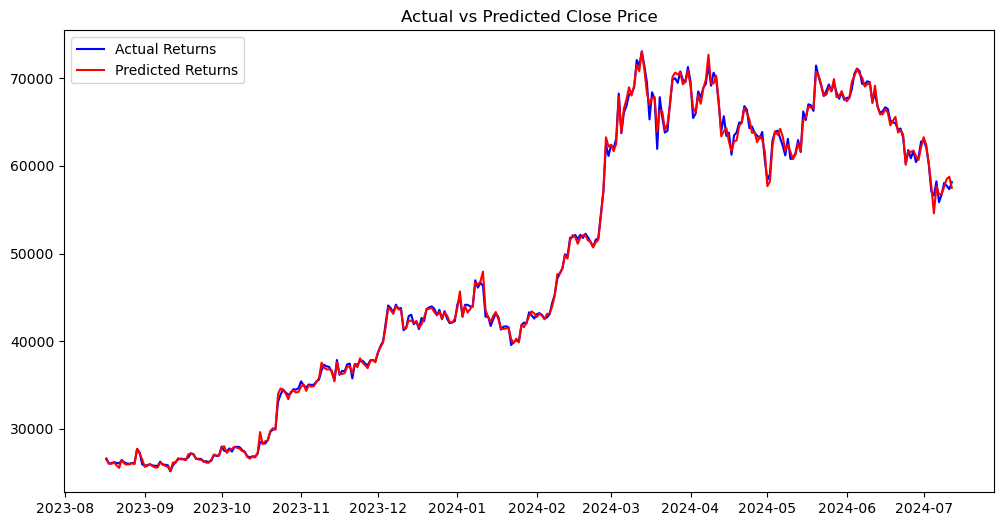

In [53]:
#Model using all available information

X = df[['open', 'high', 'low', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']]
y = df['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Returns', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Returns', color='red')
plt.title('Actual vs Predicted Close Price')
plt.legend()

Predicting closing price using lags

In [54]:
#Model using lags

#Returns column
df['returns'] = np.log(df.close.pct_change() + 1)

#Define function for lags using returns
def lagit(df, lags):
    names = []
    for i in range(1, lags+1):
        df['Lag_' + str(i)] = df['returns'].shift(i)
        names.append('Lag_' + str(i))
    return names

#Call function with associated amount of lags
lagnames = lagit(df, 5)
df.dropna(inplace=True)

In [55]:
df

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,returns,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
timestamp,,,,,,,,,,,,,,,,,
2020-01-07,7758.90,8207.68,7723.71,8145.28,91171.684661,1578441599999,7.242028e+08,685315.0,46192.111549,3.668670e+08,0,0.048714,0.052834,0.000631,0.001245,0.053015,-0.033200
2020-01-08,8145.92,8455.00,7870.00,8055.98,112622.642640,1578527999999,9.264102e+08,830375.0,55071.109514,4.532843e+08,0,-0.011024,0.048714,0.052834,0.000631,0.001245,0.053015
2020-01-09,8054.72,8055.96,7750.00,7817.76,64239.519830,1578614399999,5.072583e+08,478800.0,31645.759221,2.498997e+08,0,-0.030017,-0.011024,0.048714,0.052834,0.000631,0.001245
2020-01-10,7817.74,8199.00,7672.00,8197.02,82406.777448,1578700799999,6.527742e+08,606101.0,42361.755307,3.358454e+08,0,0.047373,-0.030017,-0.011024,0.048714,0.052834,0.000631
2020-01-11,8198.86,8286.34,8003.16,8020.01,54810.032667,1578787199999,4.450343e+08,469131.0,27916.124974,2.267160e+08,0,-0.021831,0.047373,-0.030017,-0.011024,0.048714,0.052834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-08,55857.81,58236.73,54260.16,56714.62,48090.204900,1720483199999,2.699943e+09,2554389.0,23963.906840,1.346498e+09,0,0.015223,-0.041594,0.027885,-0.007411,-0.053887,-0.031502
2024-07-09,56714.61,58296.00,56289.45,58050.00,27732.207880,1720569599999,1.592351e+09,1757693.0,14143.250010,8.122493e+08,0,0.023273,0.015223,-0.041594,0.027885,-0.007411,-0.053887
2024-07-10,58050.00,59470.00,57157.79,57725.85,24951.737990,1720655999999,1.452293e+09,1766696.0,12423.531620,7.232096e+08,0,-0.005600,0.023273,0.015223,-0.041594,0.027885,-0.007411


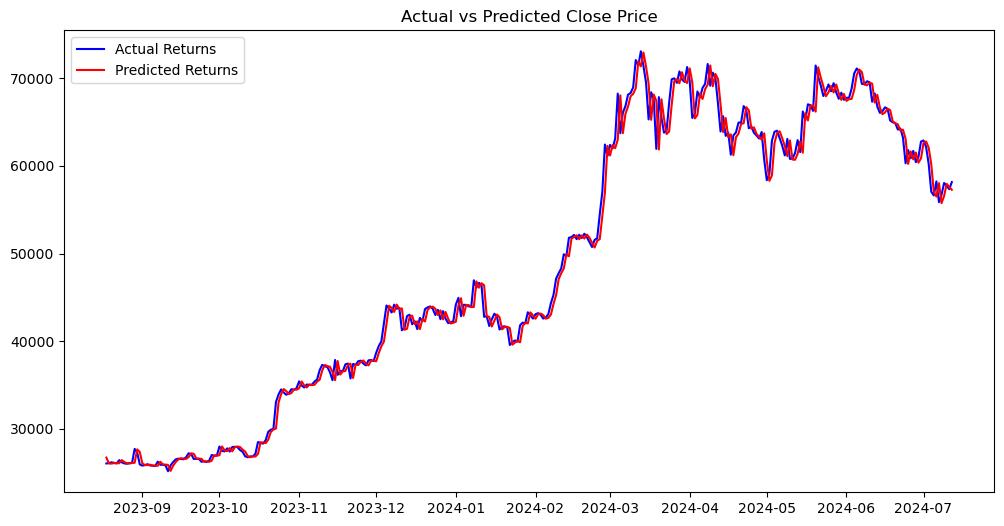

In [56]:
#Build and plot model
X = df[['open'] + lagnames]
y = df['close']

lr = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Returns', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Returns', color='red')
plt.title('Actual vs Predicted Close Price')
plt.legend()

In [59]:
# Calculate metrics
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.6f}")
print(f"Root Mean Squared Error: {rmse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"R-squared Score: {r2:.6f}")

Mean Squared Error: 1960589.850889
Root Mean Squared Error: 1400.210645
Mean Absolute Error: 927.343462
R-squared Score: 0.992005
